In [1]:
import os
import torch
from torch.utils.data import DataLoader
from brainfm.models import load_model_base, ModalityEncoder
from brainfm.data import MultiModMRIDataset, mri_collate_fn
from brainfm.utils import load_json

/Users/khueluu/Documents/Projects/brainfm/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_pretrained_model(ckpt_path: str, device: torch.device) -> torch.nn.Module:
    model = load_model_base()
    model.to(device)
 
    if ckpt_path and os.path.isfile(ckpt_path):
        print(f"Loading model weights from checkpoint: {ckpt_path}")
        checkpoint = torch.load(ckpt_path, map_location=device)
        model.load_state_dict(checkpoint["model_state_dict"])

    return model

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint_path = "checkpoint/checkpoint_49.pth"
model = load_pretrained_model(checkpoint_path, device)
model.eval()

Loading model weights from checkpoint: checkpoint/checkpoint_49.pth


BrainFM(
  (patch_proj): Linear(in_features=4096, out_features=768, bias=True)
  (modality_proj): Identity()
  (pos_embed): LearnablePositionalEmbedding3D()
  (encoder): ModalityAdaptedEncoder(
    (layers): ModuleList(
      (0-11): 12 x ModalityAdaptedTransformerBlock(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (linear1): Linear(in_features=768, out_features=3072, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=3072, out_features=768, bias=True)
        (norm1): ConditionalLayerNorm(
          (gamma_mlp): Linear(in_features=768, out_features=768, bias=True)
          (beta_mlp): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): ConditionalLayerNorm(
          (gamma_mlp): Linear(in_features=768, out_features=768, bias=True)
          (beta_mlp): Linear(in_features=768, out_features=768, bia

In [4]:
# Load json sample dict and change the root paths to local
import os

sample_dict = load_json("brats-ssa.json")

for id_, modalities in sample_dict.items():
    for modality, path in modalities.items():
        new_path = path.replace("/datastorage/brainfm/raw/", "/Volumes/BACH2TB/Datasets/")
        assert os.path.exists(new_path), f"File does not exist: {new_path}"
        sample_dict[id_][modality] = new_path

In [5]:
sample_dict

{'BraTS-SSA-00002-000/1': {'t1c': '/Volumes/BACH2TB/Datasets/BraTS25/BraTS25-SSA/ASNR-MICCAI-BraTS2023-SSA-Challenge-TrainingData_V2/BraTS-SSA-00002-000/BraTS-SSA-00002-000-t1c.nii.gz',
  't1n': '/Volumes/BACH2TB/Datasets/BraTS25/BraTS25-SSA/ASNR-MICCAI-BraTS2023-SSA-Challenge-TrainingData_V2/BraTS-SSA-00002-000/BraTS-SSA-00002-000-t1n.nii.gz',
  't2f': '/Volumes/BACH2TB/Datasets/BraTS25/BraTS25-SSA/ASNR-MICCAI-BraTS2023-SSA-Challenge-TrainingData_V2/BraTS-SSA-00002-000/BraTS-SSA-00002-000-t2f.nii.gz',
  't2w': '/Volumes/BACH2TB/Datasets/BraTS25/BraTS25-SSA/ASNR-MICCAI-BraTS2023-SSA-Challenge-TrainingData_V2/BraTS-SSA-00002-000/BraTS-SSA-00002-000-t2w.nii.gz'},
 'BraTS-SSA-00007-000/1': {'t1c': '/Volumes/BACH2TB/Datasets/BraTS25/BraTS25-SSA/ASNR-MICCAI-BraTS2023-SSA-Challenge-TrainingData_V2/BraTS-SSA-00007-000/BraTS-SSA-00007-000-t1c.nii.gz',
  't1n': '/Volumes/BACH2TB/Datasets/BraTS25/BraTS25-SSA/ASNR-MICCAI-BraTS2023-SSA-Challenge-TrainingData_V2/BraTS-SSA-00007-000/BraTS-SSA-00007-

In [6]:
dataset = MultiModMRIDataset(
    sample_dict=sample_dict,
    modality_encoder=ModalityEncoder(),
    patch_size=(16, 16, 16),
    precompute_modalities=True,
    cache_device="cpu",
)

data_loader = DataLoader(
    dataset,
    batch_size=2,
    collate_fn=mri_collate_fn,
    pin_memory=False,
    num_workers=4,
    shuffle=True,
)

In [7]:
len(dataset)

60

In [8]:
dataset[0]["images"].shape

torch.Size([4, 128, 128, 128])

In [10]:
import torch
from tqdm import tqdm

# Switch model to evaluation mode
model.eval()

all_features = []
all_labels = []

# Optional mapping for modality labels
labels_map = {
    "t1n": 0,
    "t1c": 1,
    "t2w": 2,
    "t2f": 3,
}

with torch.no_grad():
    for batch in tqdm(data_loader, desc="Extracting features"):
        images = batch["images"].to(device)           # (B, M, D, H, W)
        mod_embs = batch["modality_embs"].to(device)  # (B, M, Em)

        # --- Extract features (one per subject) ---
        feats = model.extract_features_from_volumes(
            images=images,
            modality_embs=mod_embs,
            return_cls=False
        )  # (B, 768)
        all_features.append(feats.cpu())

# --- Concatenate and save ---
all_features = torch.cat(all_features, dim=0)  # (N, 768)
all_labels = torch.tensor(all_labels)

save_dict = {"features": all_features}
torch.save(save_dict, "brainfm_features2.pt")

print(f"Saved {all_features.shape[0]} feature vectors to brainfm_features2.pt")


Extracting features: 100%|██████████| 30/30 [02:50<00:00,  5.69s/it]

Saved 60 feature vectors to brainfm_features2.pt


In [ ]:
# batch = next(iter(data_loader))
# images = batch["images"]
# mod_embs = batch["modality_embs"]
# mod_mask = batch["modality_mask"]
# print("images shape:", batch["images"].shape)
# print("modality_embs shape:", batch["modality_embs"].shape)
# print("modality_mask shape:", batch["modality_mask"].shape)

# features = model.extract_features_from_volumes(
#     images=images.to(device),
#     modality_embs=mod_embs.to(device),
# )

images shape: torch.Size([2, 4, 128, 128, 128])
modality_embs shape: torch.Size([2, 4, 768])
modality_mask shape: torch.Size([2, 4])


In [11]:
data = torch.load("brainfm_features2.pt")
features = data["features"].cpu().numpy()
features.shape

(60, 768)

/Users/khueluu/Documents/Projects/brainfm/venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


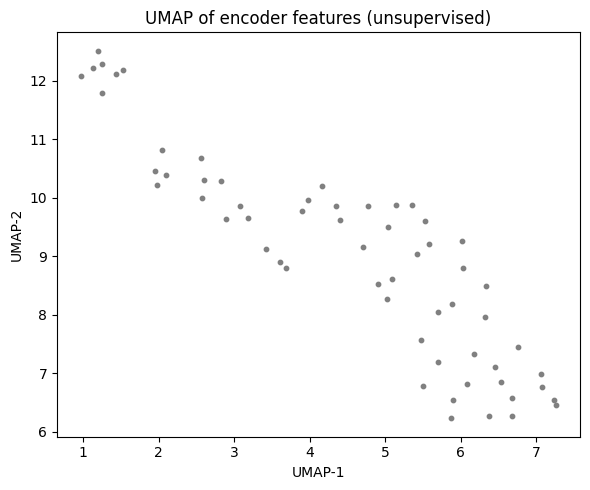

In [12]:
import matplotlib.pyplot as plt
from umap import UMAP

emb2d = UMAP(n_neighbors=15, min_dist=0.1, random_state=0).fit_transform(features)

plt.figure(figsize=(6, 5))
plt.scatter(emb2d[:, 0], emb2d[:, 1], s=10, color="gray")
plt.title("UMAP of encoder features (unsupervised)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()
plt.show()


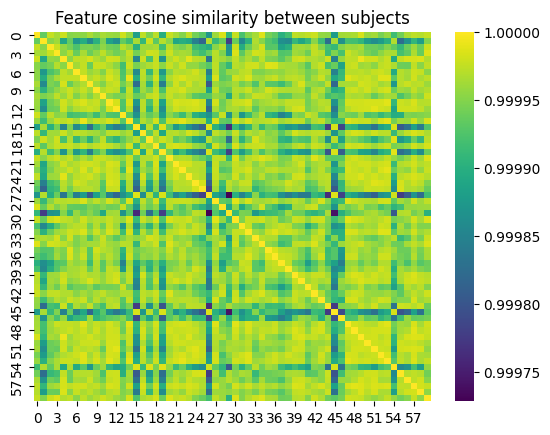

In [13]:
# Cosine similarity heatmap
import torch, matplotlib.pyplot as plt
import seaborn as sns
from torch.nn.functional import normalize

X = normalize(all_features, dim=1)
sim = X @ X.T        # (N, N)
sns.heatmap(sim.numpy(), cmap="viridis")
plt.title("Feature cosine similarity between subjects")
plt.show()


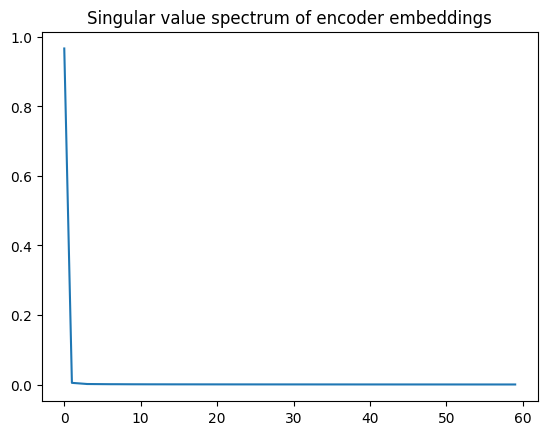

In [17]:
# Singular Value Sprectrum

import numpy as np
u, s, _ = np.linalg.svd(features, full_matrices=False)
plt.plot(s / s.sum())
plt.title("Singular value spectrum of encoder embeddings")
plt.show()


In [15]:
# Cross-modsality robustness
for m in [1,2,3,4]:
    feats_m = model.extract_features_from_volumes(images[:,:m], mod_embs[:,:m])
    sim = torch.nn.functional.cosine_similarity(feats, feats_m)
    print(f"Mean similarity using first {m} modalities:", sim.mean().item())


Mean similarity using first 1 modalities: 0.9973703622817993
Mean similarity using first 2 modalities: 0.9974250793457031
Mean similarity using first 3 modalities: 0.9975559115409851
Mean similarity using first 4 modalities: 0.9975759387016296
